# Unsupervised Learning - Cluster Modeling

In [680]:
# Imports
import pandas as pd
import numpy as np
import umap
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import altair as alt
from vega_datasets import data

In [681]:
# Select data
datasets = [
    "../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv",
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv",
]

OECD = False  # False for WB data
if OECD:
    df = pd.read_csv(datasets[0])
    mm_ind = "MATIMATM"
else:
    df = pd.read_csv(datasets[1])
    mm_ind = "SH.STA.MMRT.NE"

In [682]:
# Utility functions


def print_scores(data, labels):
    """Prints 3 evaluation metrics for clustering results"""

    ss = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)

    return "Silhouette: {:0.3f}, DB_index: {:0.3f}, C-H_index: {:0.3f}".format(
        ss, dbi, chi
    )


def add_info_to_reduced(reduced, original, labels):
    """Transformed reduced data into a dataframe and adds country and cluster info"""
    reduced = pd.DataFrame(reduced)
    reduced.columns = reduced.columns.astype(str)
    reduced["Cluster"] = list(labels)
    reduced["Country"] = list(original["Country"])

    return reduced


def viz_reduction(source, params):
    """Produces 2D chart of reduced data"""

    # Alter scale
    set_scale = [alt.Scale(), alt.Scale()]
    if params["scale"]:
        set_scale = [
            alt.Scale(domain=params["scale"]["x"]),
            alt.Scale(domain=params["scale"]["y"]),
        ]

    # Produce chart
    chart = (
        alt.Chart(source)
        .mark_circle(clip=True)
        .encode(
            x=alt.X("0", title="Component 1", scale=set_scale[0]),
            y=alt.Y("1", title="Component 2", scale=set_scale[1]),
            color=alt.Color("Cluster:O", scale=alt.Scale(scheme="category10")),
            tooltip=["Country"],
        )
        .properties(
            title="{} Visualization of OECD Nations using {} {} Indicators, for {}".format(
                "UMAP", params["dataset"], params["theme"], params["year"]
            ),
            width=500,
            height=500,
        )
        # .configure_axis(grid=False)
    )

    return chart


def world_map(clusters, params):
    """Produces a world map with clusters"""

    world_data = alt.topo_feature(data.world_110m.url, "countries")
    ocean = alt.Chart(alt.sphere()).mark_geoshape(fill="lightblue")

    countries = (
        alt.Chart(world_data)
        .mark_geoshape(stroke="black", strokeWidth=0.15)
        .encode(color=alt.Color("Cluster:O", scale=alt.Scale(scheme="category10")))
        .transform_lookup(
            lookup="id",
            from_=alt.LookupData(
                pd.DataFrame({"ISO": iso_codes, "Cluster": clusters}),
                "ISO",
                ["Cluster"],
            ),
        )
    )

    world_map = (
        (ocean + countries)
        .project("naturalEarth1")
        .properties(
            width=1000,
            height=500,
            title="{} Clustering of OECD Nations using {} {} Indicators, for {}".format(
                params["method"], params["dataset"], params["theme"], params["year"]
            ),
        )
    )

    return world_map

## Data Preparation

In [683]:
# Reduce to only gender-themed indicators for WB

if not OECD:
    gender_ind = pd.read_csv("../WorldBankDatasets/Gender_WorldBankData.csv").columns
    df = df.drop(columns=[col for col in df if col not in gender_ind])

df.head()

,Country,Year,SE.ENR.PRIM.FM.ZS,SE.ENR.PRSC.FM.ZS,SE.ENR.SECO.FM.ZS,SE.ENR.TERT.FM.ZS,SE.PRE.ENRR.FE,SE.PRE.ENRR.MA,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,...,SP.POP.AG01.FE.IN,SP.POP.AG01.MA.IN,SP.POP.AG02.FE.IN,SP.POP.AG02.MA.IN,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN
0,AUS,1997,0.416833,0.590957,0.561862,0.602762,0.716846,0.701958,0.618923,0.596648,...,0.061052,0.061697,0.061782,0.062388,0.061998,0.062655,0.061625,0.062167,0.062101,0.062484
1,AUS,2000,0.485202,0.529175,0.508456,0.689233,0.716846,0.701958,0.516857,0.512608,...,0.060289,0.060719,0.060532,0.061015,0.061063,0.061656,0.061521,0.062078,0.062480,0.063055
2,AUS,2003,0.486447,0.529175,0.508456,0.689233,0.646672,0.615112,0.509459,0.512607,...,0.059912,0.060465,0.060653,0.061073,0.061127,0.061457,0.060834,0.061178,0.061202,0.061616
3,AUS,2006,0.451160,0.529175,0.508456,0.689233,0.635930,0.630876,0.509459,0.512607,...,0.062087,0.062898,0.061253,0.061967,0.060915,0.061498,0.060854,0.061240,0.061753,0.062043
4,AUS,2011,0.396130,0.390055,0.341161,0.802866,0.834622,0.830254,0.609770,0.608711,...,0.070399,0.071178,0.070402,0.070956,0.069563,0.070234,0.068274,0.068947,0.067622,0.068356


In [684]:
# Select year and drop country
year = 2015
df = df[df["Year"] == year]

# Scale predictor
# scaler = MinMaxScaler()
# df[mm_ind] = scaler.fit_transform(df[mm_ind].to_numpy().reshape(-1, 1))

# Drop year, country, and predictor
X = df.drop(columns=["Country", "Year", mm_ind])

In [685]:
# Produce mapping, used for world map visualizations
# Source: https://gist.github.com/radcliff/f09c0f88344a7fcef373

mapping_name_to_iso = (
    pd.read_csv("../misc/wikipedia-iso-country-codes.csv")
    .set_index("Alpha-3 code")
    .to_dict()["Numeric code"]
)

iso_codes = [mapping_name_to_iso[c] for c in df["Country"].unique()]

In [686]:
# Set parameters for visualizations
params = {}
params["dataset"] = "OECD" if OECD else "World Bank"
params["theme"] = "Gender" if not OECD else "All"
params["year"] = year
params["scale"] = None

## Dimensionality Reduction with UMAP

In [687]:
# Change parameters depending on dataset

embeddings = umap.UMAP(
    n_components=2, n_neighbors=3, min_dist=(0 if not OECD else 0.1), random_state=42
).fit_transform(X)

/home/smonem/MADS_MilestoneII/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


## K-Means Clustering

### Hyperparameter Tuning

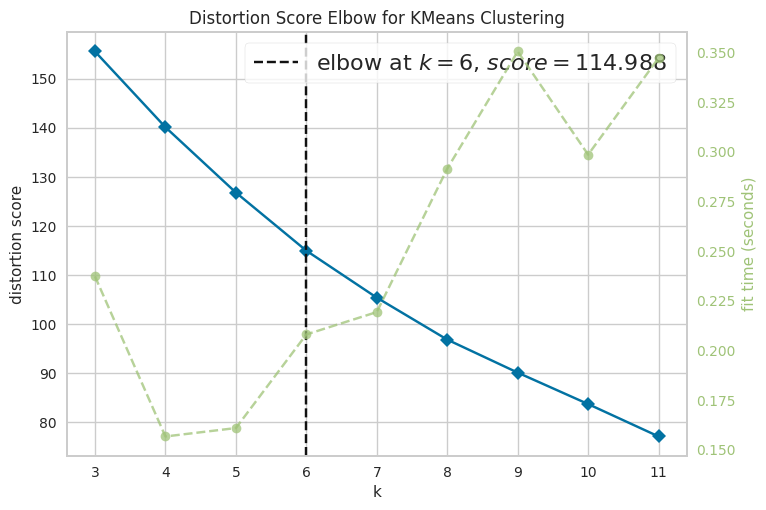

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [688]:
# Select number of clusters using "elbow" heuristic and distortion score

k_range = range(3, 12)
kmeans = KMeans(n_init=100, random_state=42)
visualizer = KElbowVisualizer(kmeans, k=k_range)

visualizer.fit(X)

best_k = visualizer.elbow_value_
visualizer.show()

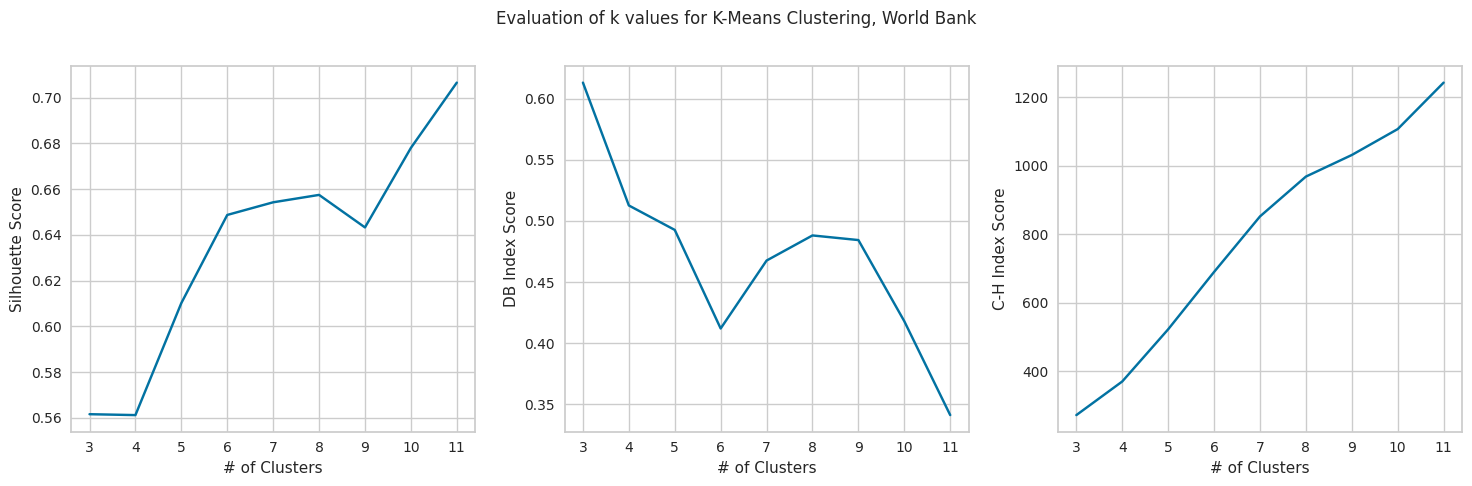

In [689]:
# Evaluation score of each k value
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

score_s = []
score_db = []
score_ch = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans.fit(embeddings)
    score_s.append(silhouette_score(embeddings, kmeans.labels_))
    score_db.append(davies_bouldin_score(embeddings, kmeans.labels_))
    score_ch.append(calinski_harabasz_score(embeddings, kmeans.labels_))

# Produce silhouette plot
ax1.plot((k_range), score_s)
ax1.set_xlabel("# of Clusters")
ax1.set_ylabel("Silhouette Score")
# ax1.grid(False)

ax2.plot((k_range), score_db)
ax2.set_xlabel("# of Clusters")
ax2.set_ylabel("DB Index Score")
# ax2.grid(False)

ax3.plot((k_range), score_ch)
ax3.set_xlabel("# of Clusters")
ax3.set_ylabel("C-H Index Score")
# ax3.grid(False)

fig.suptitle(
    "Evaluation of k values for K-Means Clustering, {}".format(params["dataset"]),
    fontsize=12,
)
plt.tight_layout()
plt.show()

In [690]:
# Override found k
best_k = 5 if OECD else best_k

In [691]:
# Get scores of best k value
kmeans = KMeans(n_clusters=best_k, n_init=100, random_state=42)
kmeans.fit(embeddings)
print_scores(embeddings, kmeans.labels_)

'Silhouette: 0.649, DB_index: 0.412, C-H_index: 689.290'

### Cluster Visualization

In [692]:
# Visualize the clusters on UMAP projection and world map
kmeans = KMeans(n_clusters=best_k, n_init=100, random_state=42)
kmeans.fit(X)

params["method"] = "K-Means"
params["scale"] = None
viz_reduction(add_info_to_reduced(embeddings, df, kmeans.labels_), params) | world_map(
    kmeans.labels_, params
)

alt.HConcatChart(...)

## Alternative Methods - Agglomerative Clustering

In [693]:
# Cluster size is selected based on number of clusters that appear visually on UMAP projection
agg = AgglomerativeClustering(n_clusters=(4 if not OECD else 5))
agg.fit(embeddings)

print_scores(embeddings, agg.labels_)

'Silhouette: 0.607, DB_index: 0.461, C-H_index: 368.787'

In [694]:
# Visualize the clusters on UMAP projection and world map
params["method"] = "Agglomerative"
params["scale"] = None
viz_reduction(add_info_to_reduced(embeddings, df, agg.labels_), params) | world_map(
    agg.labels_, params
)

alt.HConcatChart(...)

## Sensitivity Analysis

## Investigation of Cluster Groups

In [695]:
# Investigating mean MMR for each cluster group
df["Cluster"] = kmeans.labels_
df.groupby("Cluster")[mm_ind].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,18.0,2.666667,2.376354,0.0,0.25,3.0,3.75,8.0
1,12.0,9.416667,15.482884,0.0,2.00,5.0,7.75,57.0
2,2.0,26.000000,11.313708,18.0,22.00,26.0,30.00,34.0
3,3.0,26.333333,17.925773,15.0,16.00,17.0,32.00,47.0
4,4.0,5.000000,1.825742,3.0,3.75,5.0,6.25,7.0
5,2.0,6.500000,3.535534,4.0,5.25,6.5,7.75,9.0
